# AllLife Bank Customer Segmentation Study

## Aim:

We have been tasked to identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Attribute Information:

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing Necessary Libraries such as pandas, numpy, matplotlib.pyplot, seaborn

In [1]:
import warnings
warnings.filterwarnings('ignore')

#numerical libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import zscore

#import panda to work with dataframe columns and rows
import pandas as pd

#import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn for statistical plots
import seaborn as sns
from sklearn.metrics import silhouette_score

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet


## Reading the data from an .xlsx file

In [2]:
#read xlsx into a dataframe called 'data' and read the second sheet
credit_data = pd.read_excel('C:/Users/zeezu/Desktop/Python Coding/csv/Credit Card Customer Data.xlsx', 'Sheet1')

In [3]:
#copying the data frame into a new data frame to retain original data.
df = pd.DataFrame(credit_data)

## Checking first 5 rows and 10 random rows to get a nice overview

In [4]:
#Checking the first 10 rows of the dataset
df.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')  # f-string

# I'm now going to look at 8 random rows
# I'm setting the random seed via np.random.seed so that I get the same random results every time
np.random.seed(1)
df.sample(10)

There are 660 rows and 7 columns.


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


## Checking the info of the dataset

In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


### Checking for missing values

In [8]:
df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [9]:
df.isnull().any()

Sl_No                  False
Customer Key           False
Avg_Credit_Limit       False
Total_Credit_Cards     False
Total_visits_bank      False
Total_visits_online    False
Total_calls_made       False
dtype: bool

* There are no apparent missing values

### Checking unique values of every column

In [10]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

* `SI No` and `Customer Key` are not needed so we shall drop these columns.

In [11]:
# Dropping SI No and Customer Key columns
df.drop(['Sl_No', 'Customer Key'],  axis=1, inplace=True)

In [12]:
#Checking if columns have been dropped
df.head(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


# Exploratory Data Analysis

## Univariate analysis

In [13]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(10,7), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=2) # setting the font scale  of the seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(feature.mean(), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(feature.median(), color='black', linestyle='-') # Add median to the histogram

### Let's explore the variable `Avg_Credit_Limit`

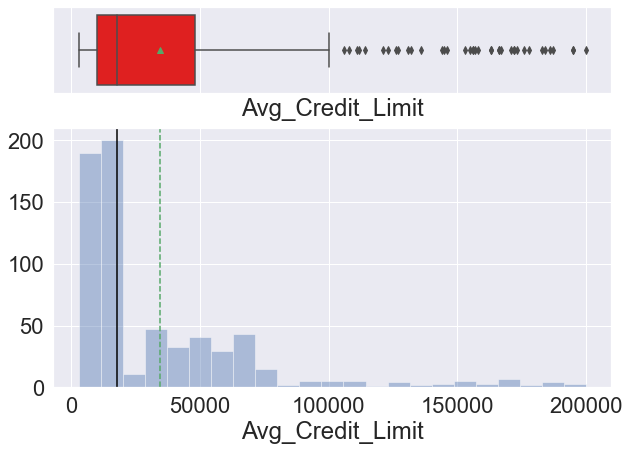

In [14]:
histogram_boxplot(df.Avg_Credit_Limit);

* This variable is highly right skewed, where we see multiple outliers to the right of the graph.

### Let's explore the variable `Total_Credit_Cards`

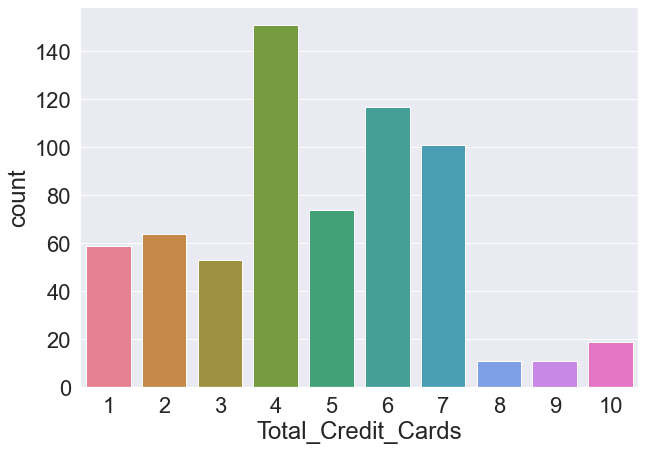

In [15]:
plt.figure(figsize=(10,7))
sns.countplot(df['Total_Credit_Cards'], palette='husl');

* We can see that alot of customers have between 4-7 credit cards.

### Let's explore the variable `Total_visits_bank`

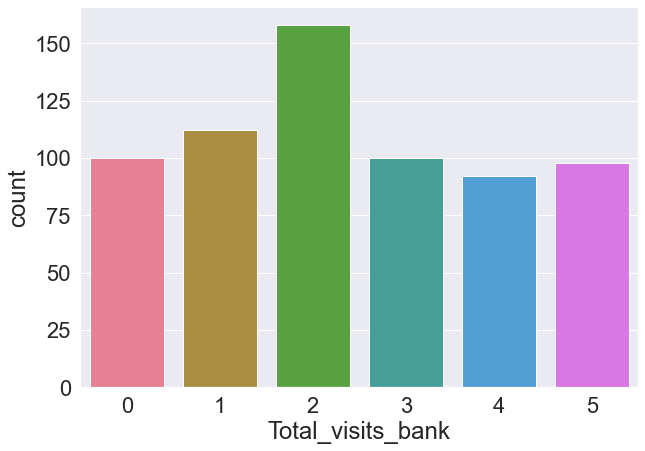

In [16]:
plt.figure(figsize=(10,7))
sns.countplot(df['Total_visits_bank'], palette='husl');

* A high number of customers have visited the bank 2  times.

### Let's explore the variable `Total_visits_online`

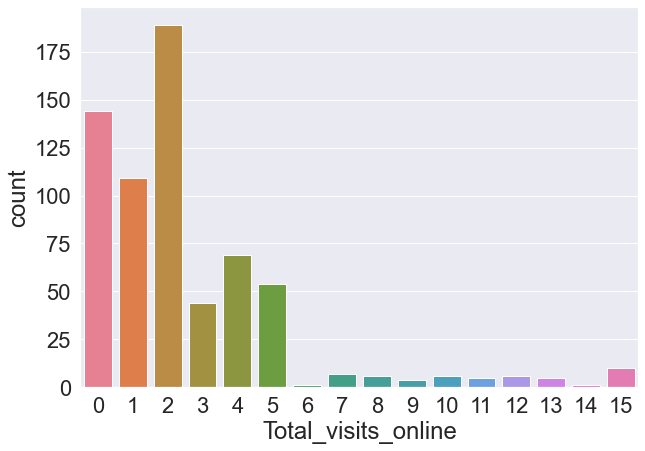

In [17]:
plt.figure(figsize=(10,7))
sns.countplot(df['Total_visits_online'], palette='husl');

* Most customers have made online logins/visits twice in the year.

### Let's explore the variable `Total_calls_made`

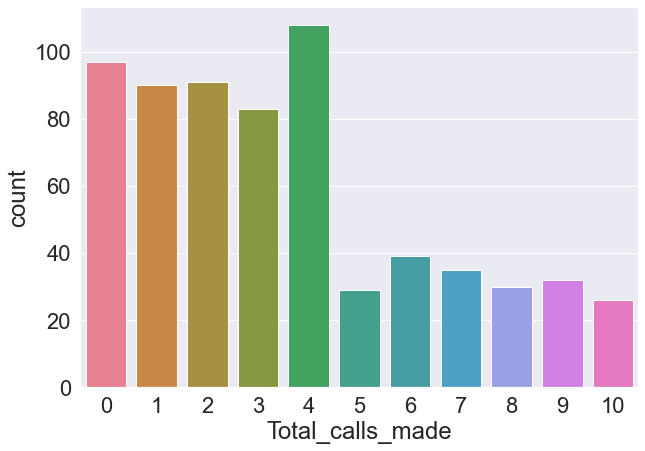

In [18]:
plt.figure(figsize=(10,7))
sns.countplot(df['Total_calls_made'], palette='husl');

* The majority of customers have made between 0-4 calls to the bank.

## Multivariate Analysis

We shall plot some graphs that shall help us take a look and understand some of the interactions between the numerous variables 

### Correlation

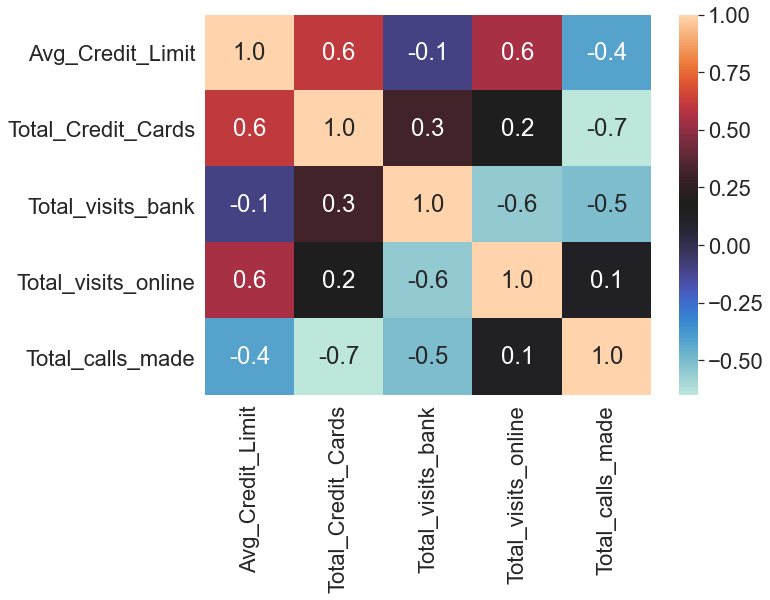

In [19]:
#We shall use a heat map to check the correlation between the variables

fig,ax = plt.subplots(figsize=(10,7));
sns.heatmap(df.corr(),ax=ax,annot=True, cmap='icefire', fmt='.1f');

### Observations

* `Avg_Credit_Limit` is somewhat positively correlated with `Total_Credit_Cards`, same goes for `Avg_Credit_Limit` and `Total_visits_online` 

## Let's look at regression plots of variables with some positive correlation 

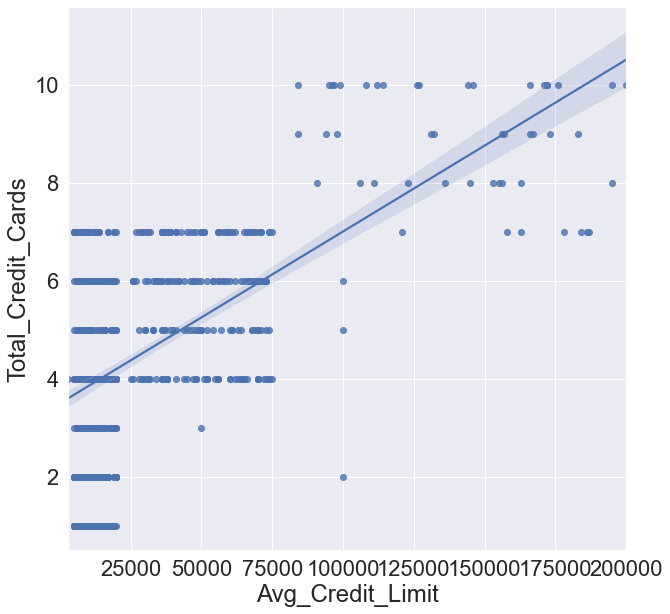

In [20]:
#We can create a regression plot that shall draw a regression line--
#--through the scatter plot to help us visualize the positive correlation

plt.figure(figsize=(10,10))
sns.regplot(x='Avg_Credit_Limit',y='Total_Credit_Cards', data=df);

* This confirms the postive correlation between these two variables which we saw earlier from the correlation plot.
* It may be indicating that the more credit cards a customer has, the higher their credit limit.

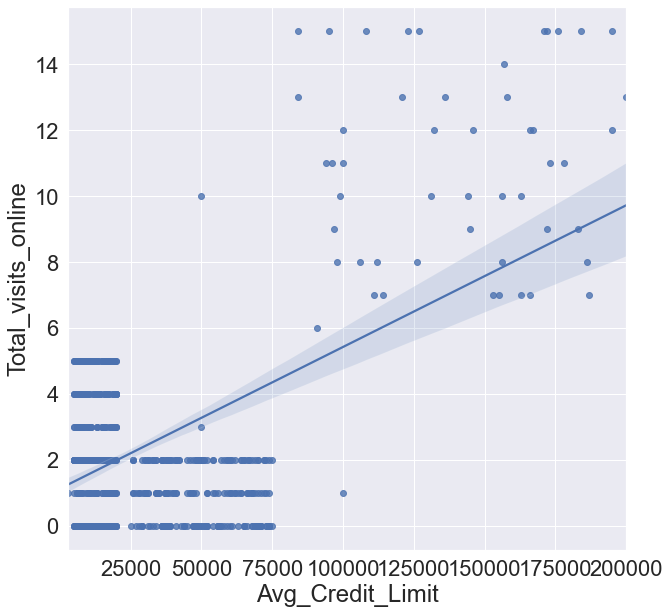

In [21]:
plt.figure(figsize=(10,10))

#Plotting a regression plot with NumberOfChildrenVisiting on the x-axis and NumberOfPersonVisiting on the y-axis
sns.regplot(x='Avg_Credit_Limit',y='Total_visits_online', data=df);

* The same goes for the variables here where we can see the positive correlation which might be indicating the more online visits a customer has, the higher their credit limit. 

## Outlier Detection

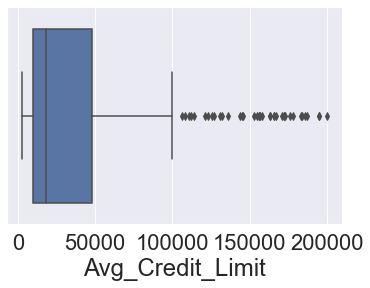

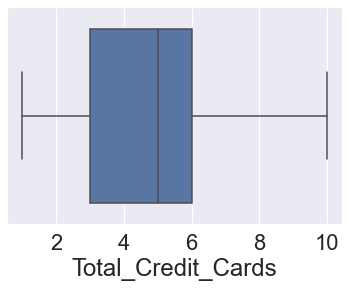

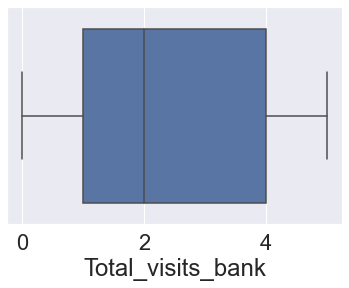

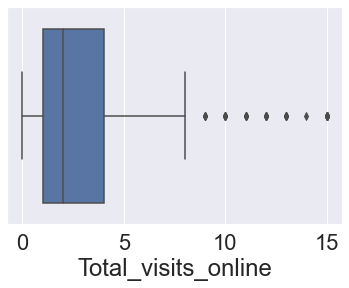

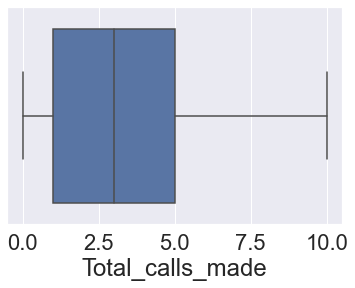

In [22]:
for feature in list(df.columns):
    sns.boxplot(x=df[feature])
    plt.show()

* There are a couple of outliers to the right in the two variables, `Avg_Credit_Limit` and `Total_visits_online`

## Scaling of the data

In [23]:
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(df),
    columns=df.columns,
)
dfsk = subset_scaled_df.copy()
dfsk.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## Elbow Method and K-means clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

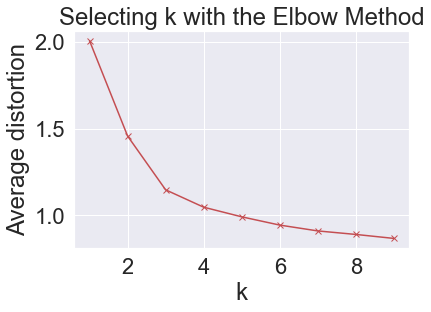

In [24]:
#Finding optimal no. of clusters
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(dfsk)
    prediction=model.predict(dfsk)
    meanDistortions.append(sum(np.min(cdist(dfsk, model.cluster_centers_, 'euclidean'), axis=1)) / dfsk.shape[0])


plt.plot(clusters, meanDistortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

* The most optimum number of clusters for this elbow graph seems to be 3, seeing as the bend at 3-4 clusters seems to be a good value.
* Therefore, we shall take K=3 for our Kmeans

In [25]:
final_model=KMeans(3)
final_model.fit(subset_scaled_df)
prediction=final_model.predict(subset_scaled_df)
prediction_using_3 = prediction

#Append the prediction 
df["GROUP"] = prediction
dfsk["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


In [26]:
dfKmeansClust = df.groupby(['GROUP'])
dfKmeansClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12174.107143,2.410714,0.933036,3.553571,6.870536


In [27]:
#setting the value of k=3
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, n_init=15, random_state=1)

In [28]:
#calculate centroids and generate their values
centroids = kmeans.cluster_centers_
centroids

array([[-0.59579625, -1.05962278, -0.9015185 ,  0.32299678,  1.14810882],
       [-0.02106178,  0.37368962,  0.6663945 , -0.55367163, -0.55300488],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983]])

In [29]:
#create centroid dataframe and print
CentroidDF = pd.DataFrame(centroids, columns = list(subset_scaled_df))
CentroidDF  #these are the centroids for all clusters

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.595796,-1.059623,-0.901518,0.322997,1.148109
1,-0.021062,0.373690,0.666395,-0.553672,-0.553005
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


The above are the centroids for the different clusters


#### Adding Label to the dataset

In [30]:
## create a new data frame for label and convert to categorical variable

KMeansData = dfsk[:]  #creating a copy of the data 

KMeansData['KmeansLabel']=kmeans.labels_

In [31]:
KMeansData.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,KmeansLabel
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0,1
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2,0
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0,1
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0,1
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1,2


In [32]:
KMeansData['KmeansLabel'].value_counts()  #this will help to find the number of data points in each group/cluster

1    386
0    224
2     50
Name: KmeansLabel, dtype: int64

In [33]:
#create model with k=3
FinalModel = KMeans(3)
FinalModel.fit(KMeansData)
prediction = FinalModel.predict(KMeansData)

#append  prediction
KMeansData['Group'] = prediction
print("Groups Assigned: \n")
KMeansData[["Avg_Credit_Limit", "Group"]]

Groups Assigned: 



,Avg_Credit_Limit,Group
0,1.740187,1
1,0.410293,0
2,0.410293,1
3,-0.121665,1
4,1.740187,2
...,...,...
655,1.713589,2
656,1.314621,2
657,2.937092,2
658,3.655235,2


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'GROUP'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'KmeansLabel'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[Group]'>],
       [<AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[Group]'>,
        <AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[Group]'>,
        <AxesSubplot:>]], dtype=object)

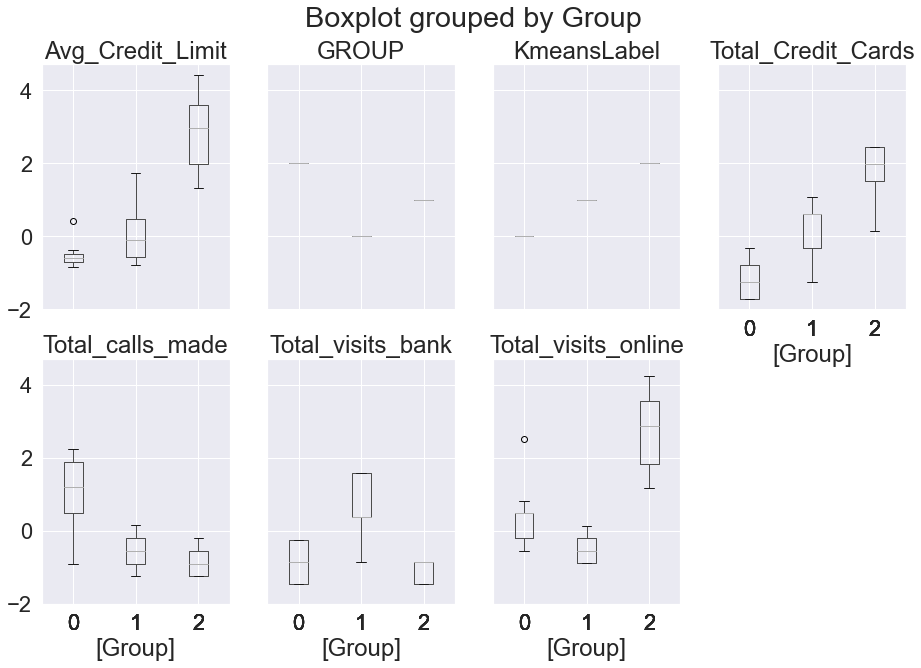

In [34]:
KMeansData.boxplot(by='Group', layout=(2, 4),
                   figsize=(15, 10))  #boxplot of all clusters

### Observations

- The customers that have high online visits also have high credit limit.
- Customers with much lower credit limits also make more calls to the bank and have less credit cards but make less visits to the bank.

## Silhouette Score for K-means

In [35]:
# Calculate & Print Silhoutte Score for KMeans

score = silhouette_score(KMeansData, FinalModel.labels_, metric='euclidean')

print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.617


In [36]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3,
                                affinity='euclidean',
                                linkage='average')
model.fit(dfsk)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [37]:
#from scipy.cluster.hierarchy import dendrogram, linkage, cophenet and pdist from scipy
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(dfsk, metric='euclidean', method='average')
c, coph_dists = cophenet(Z, pdist(dfsk))
c

0.9250834137612217

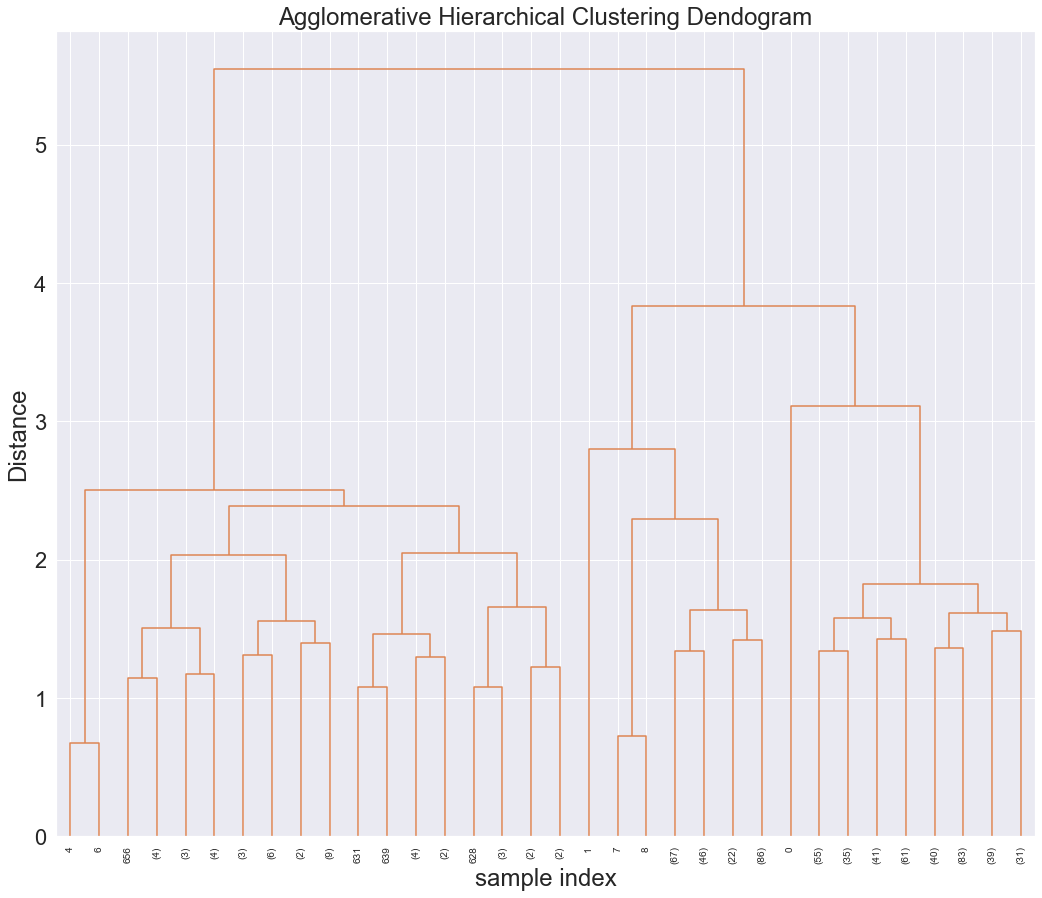

In [38]:
plt.figure(figsize=(15, 13))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,
           leaf_rotation=90,
           p=5,
           color_threshold=40,
           leaf_font_size=10,
           truncate_mode='level')
plt.tight_layout()

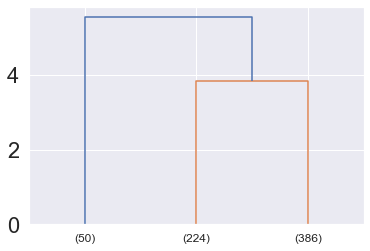

In [39]:
#find optimal distance
dendrogram(
    Z,
    truncate_mode='lastp',  #show only last p clusters
    p=3,  #show only the last p merged clusters    
)
plt.show()

#we have the same size clusters with both kmeans and hierarchical methods

#### Plotting different dendograms for different linkage methods and choosing the best based on cophenetic coeff

In [40]:
Z_single = linkage(dfsk, metric='euclidean', method='single')
c_single, coph_dists_single = cophenet(Z_single , pdist(dfsk))
c_single

0.8452796130290009

In [41]:
Z_ward = linkage(dfsk, metric='euclidean', method='ward')
c_ward, coph_dists_ward = cophenet(Z_ward , pdist(dfsk))
c_ward

0.8165335196932614

In [42]:
Z_avg = linkage(dfsk, metric='euclidean', method='average')
c_avg, coph_dists_avg = cophenet(Z_avg , pdist(dfsk))
c_avg

0.9250834137612217

In [43]:
Z_complete = linkage(dfsk, metric='euclidean', method='complete')
c_complete, coph_dists_complete = cophenet(Z_complete , pdist(dfsk))
c_complete

0.8965261555242725

In [44]:
Z_weighted = linkage(dfsk, metric='euclidean', method='weighted')
c_weighted, coph_dists_weighted = cophenet(Z_weighted , pdist(dfsk))
c_weighted

0.9046825226680215

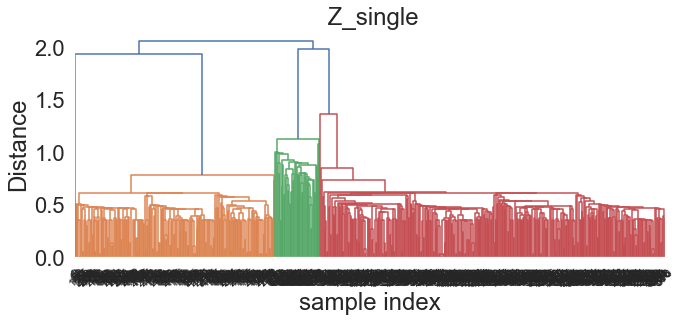

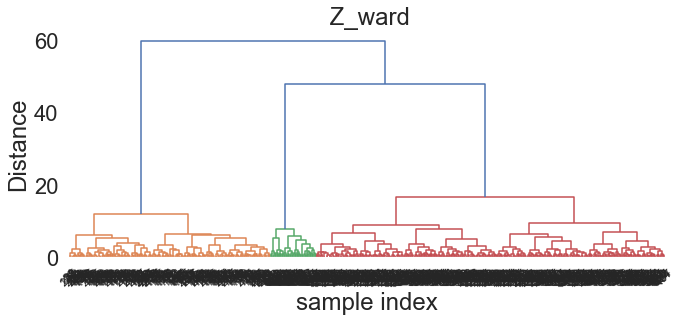

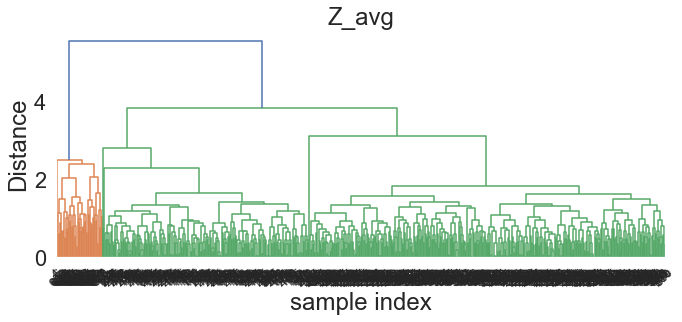

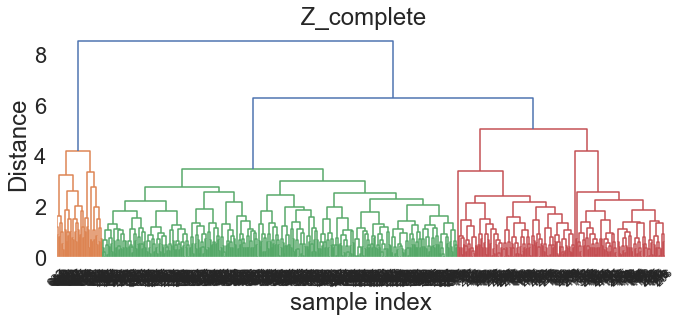

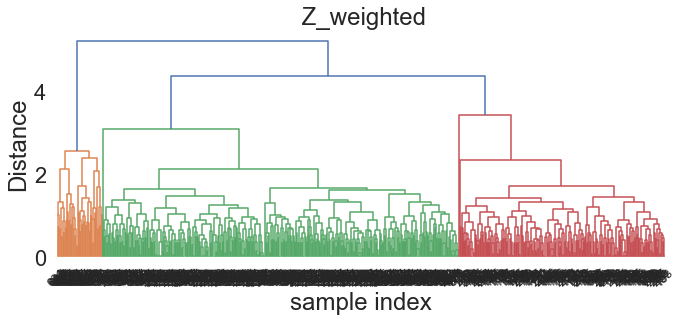

In [45]:
temp = [' Z_single',' Z_ward', 'Z_avg',' Z_complete',' Z_weighted']
j=0
for i in [Z_single, Z_ward, Z_avg, Z_complete, Z_weighted]:
    
    plt.figure(figsize=(10, 5))
    plt.title(temp[j])
    j=j+1
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(i,  leaf_rotation=45 , leaf_font_size=12 )
    plt.tight_layout()

In [46]:
# Let us try with K = 3 (to demonstrate the 3d plot using mplot3d)
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, '3D plot of KMeans Clustering')

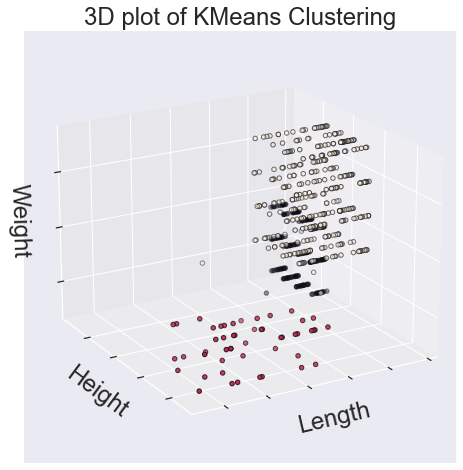

In [47]:
## 3D plots of clusters

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
k3_model=KMeans(3)
k3_model.fit(subset_scaled_df)
labels = k3_model.labels_
ax.scatter(dfsk.iloc[:, 0], dfsk.iloc[:, 1], dfsk.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

Text(0.5, 0.92, '3D plot of KMeans Clustering')

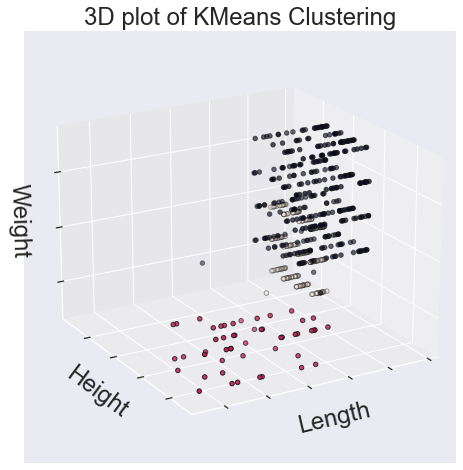

In [48]:
## 3D plots of clusters

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
k3_model=KMeans(3)
k3_model.fit(subset_scaled_df)
labels = k3_model.labels_
ax.scatter(dfsk.iloc[:, 0], dfsk.iloc[:, 1], dfsk.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

In [49]:
# Check the number of data in each cluster

labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[224 386  50]


In [50]:
# Distribution looks fine.

# let us check the centers in each group
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(subset_scaled_df) )
centroid_df.transpose()

,0,1,2
Avg_Credit_Limit,-0.595796,-0.021062,2.831764
Total_Credit_Cards,-1.059623,0.373690,1.862226
Total_visits_bank,-0.901518,0.666395,-1.105763
Total_visits_online,0.322997,-0.553672,2.827319
Total_calls_made,1.148109,-0.553005,-0.874330


In [51]:
# Add cluster number to original credit_card data

predictions = kmeans.predict(subset_scaled_df)
predictions
df["group"] = predictions
df['group'] = df['group'].astype('category')
df.dtypes

Avg_Credit_Limit          int64
Total_Credit_Cards        int64
Total_visits_bank         int64
Total_visits_online       int64
Total_calls_made          int64
GROUP                     int32
group                  category
dtype: object

In [52]:
hierarchy = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
hierarchy_fit = hierarchy.fit(subset_scaled_df)

In [53]:
subset_scaled_df['labels_hierarchy'] = hierarchy_fit.labels_
subset_scaled_df['labels_hierarchy'] = hierarchy_fit.labels_
subset_scaled_df['labels_hierarchy'] = hierarchy_fit.labels_ 
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels_hierarchy
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[group]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[group]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[group]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[group]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[group]'>,
        <AxesSubplot:title={'center':'labels_hierarchy'}, xlabel='[group]'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

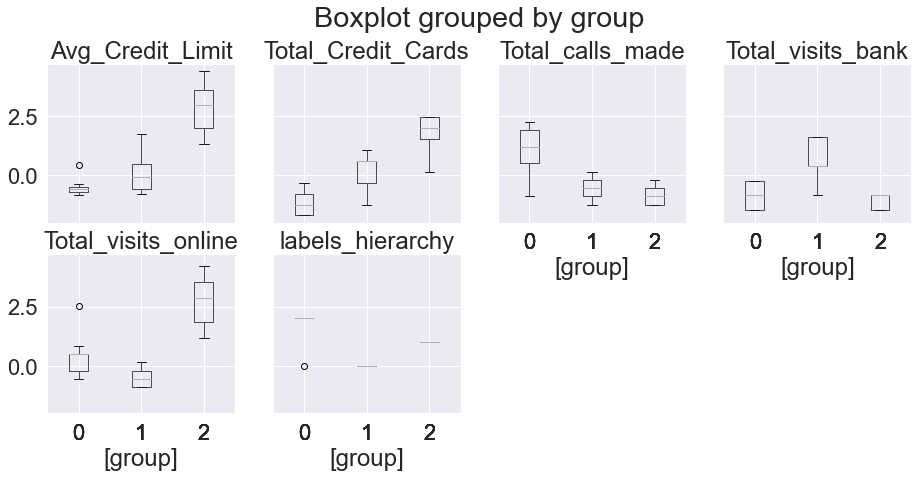

In [54]:
#now we are going to visualize the centers

subset_scaled_df["group"] = predictions
subset_scaled_df.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

In [55]:
from sklearn.metrics import silhouette_score
print ('The Silhouette Score for Heirarchy method is: ', silhouette_score(subset_scaled_df, hierarchy_fit.labels_))

The Silhouette Score for Heirarchy method is:  0.6045405681780777


- Since the score is greater than 0.5, this means our clustering is good. Also the scores for both Kmeans and Hierachy are relatively the same, indicating they are both decent algorithms for the given data.

## Silhouette plot on K-Means clustering

In [56]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

In [57]:
X = subset_scaled_df.to_numpy()
X.shape

(660, 7)

For n_clusters = 2 The average silhouette_score is : 0.513716277163439
For n_clusters = 3 The average silhouette_score is : 0.6045405681780777
For n_clusters = 4 The average silhouette_score is : 0.3948442919288554
For n_clusters = 5 The average silhouette_score is : 0.2767600892472615
For n_clusters = 6 The average silhouette_score is : 0.25930902969778613


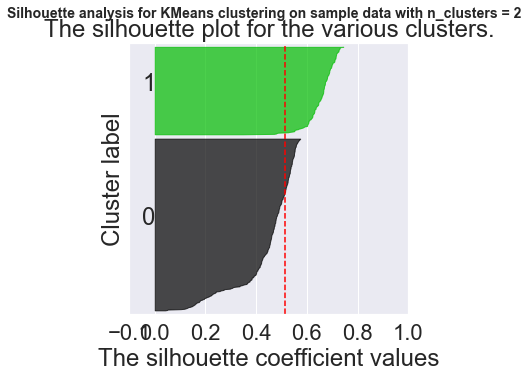

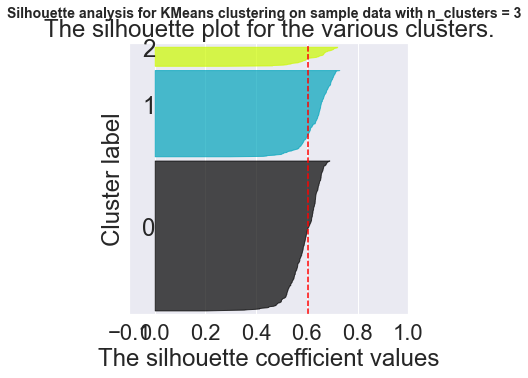

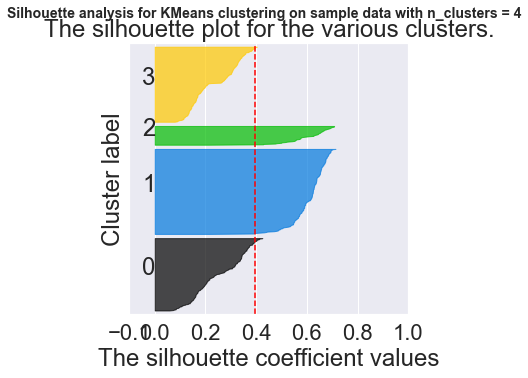

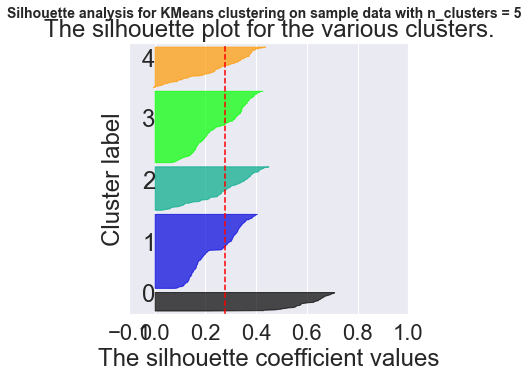

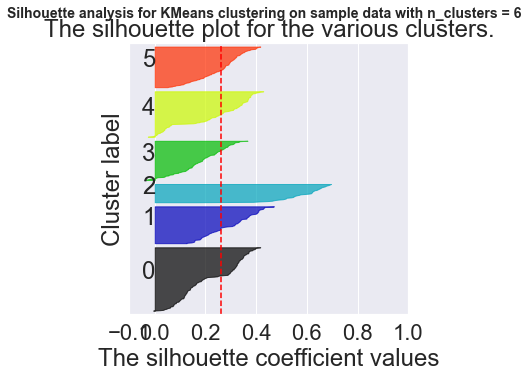

In [58]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
  
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Observations
* This clearly shows the most optimum number for our number of clusters is 3 seeing as it has the highest score.

## Hierarchical Clustering

Hierarchical clustering with different dendograms for the same dataset and choosing the best using the cophenetic coefficient by using different types of linkages

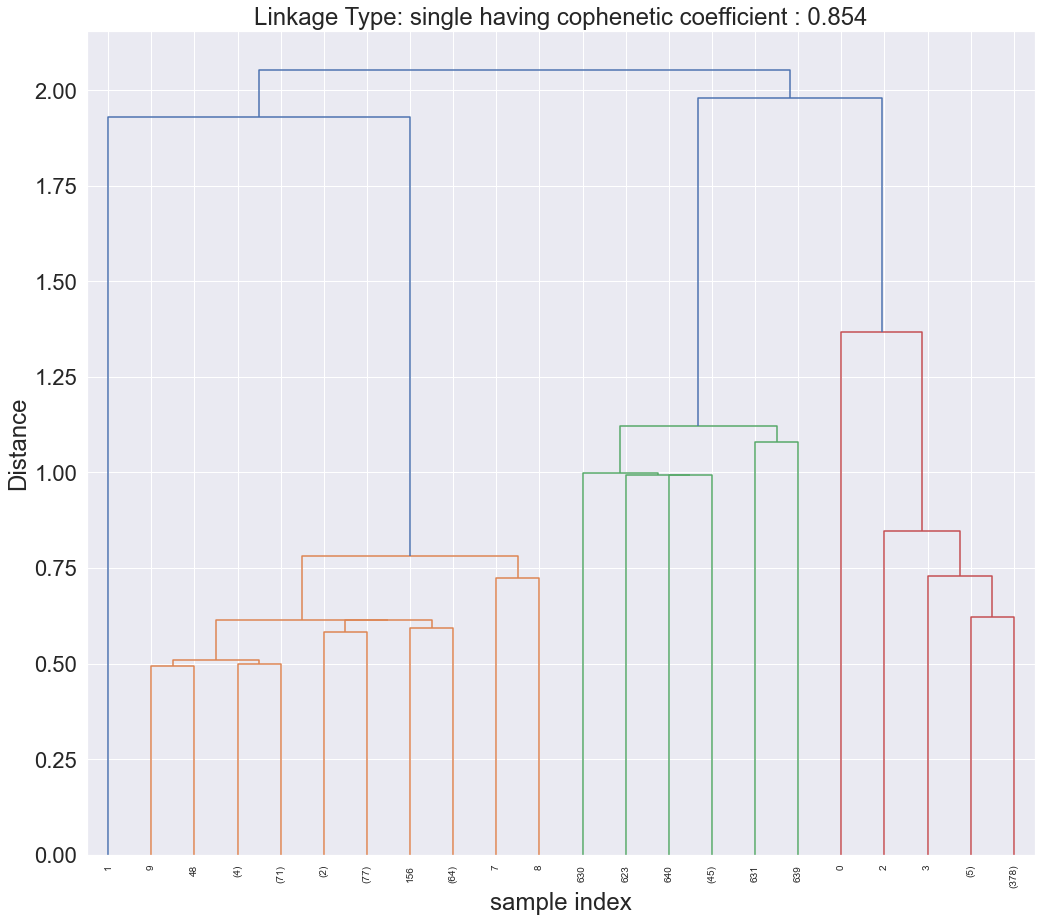

single 0.8543635016652695


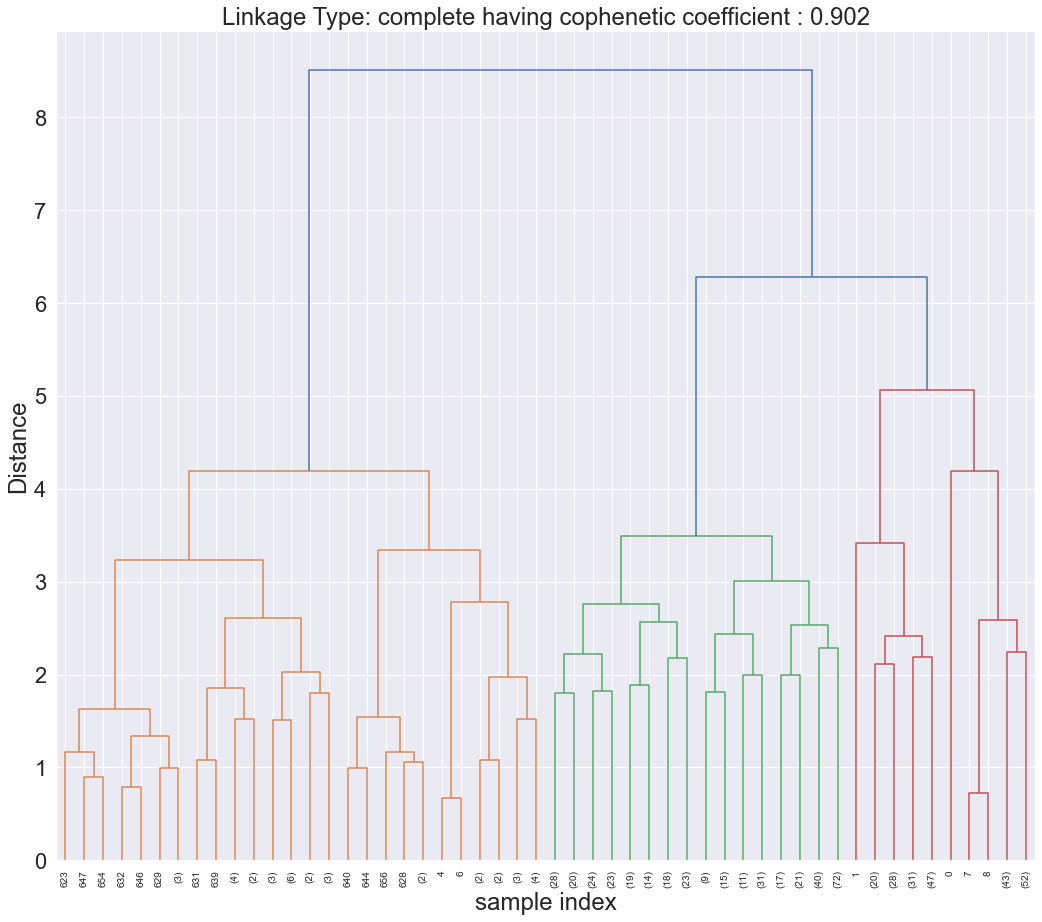

complete 0.9024129387161871


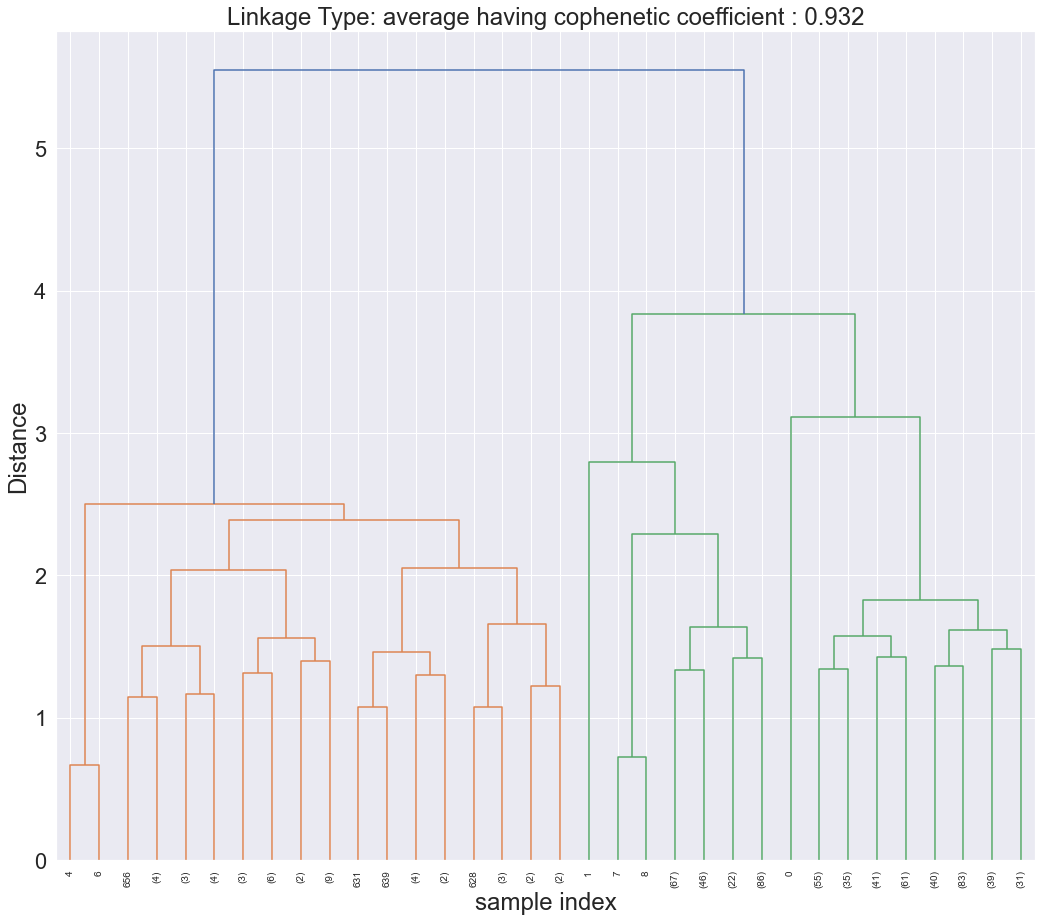

average 0.9315026177618616


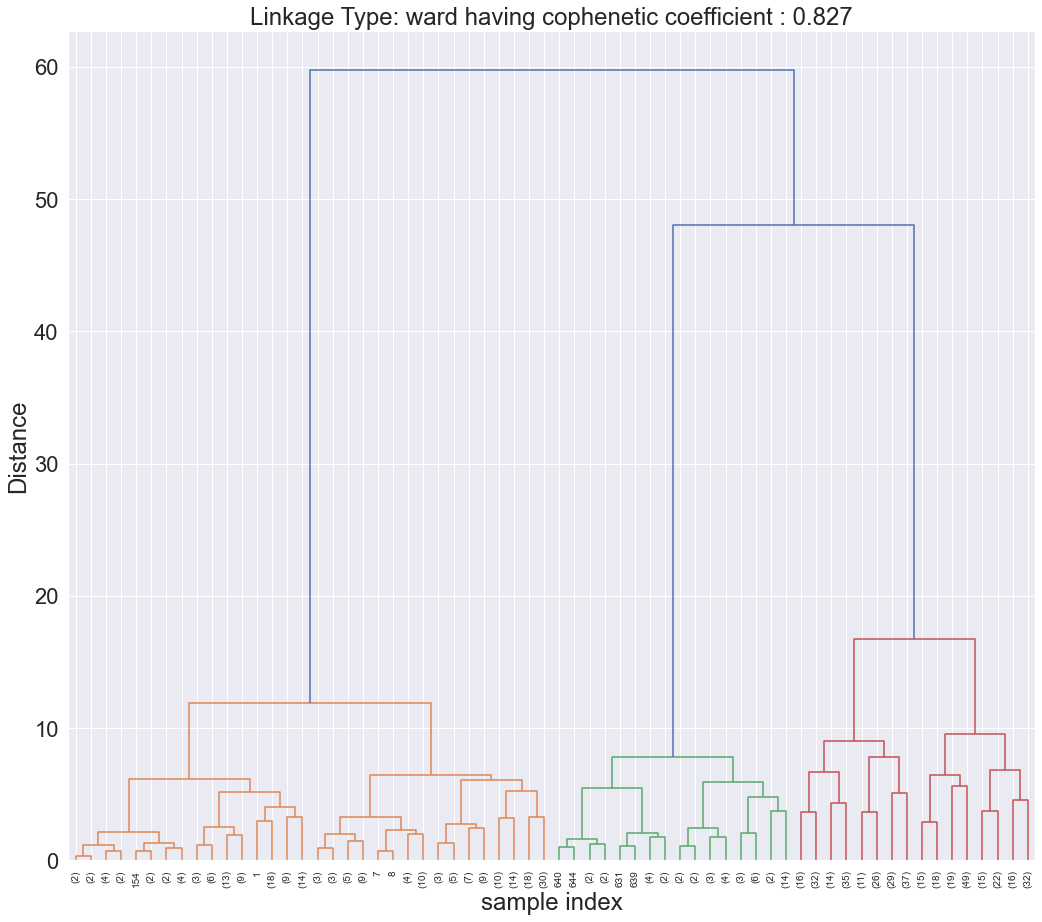

ward 0.8270604984416535


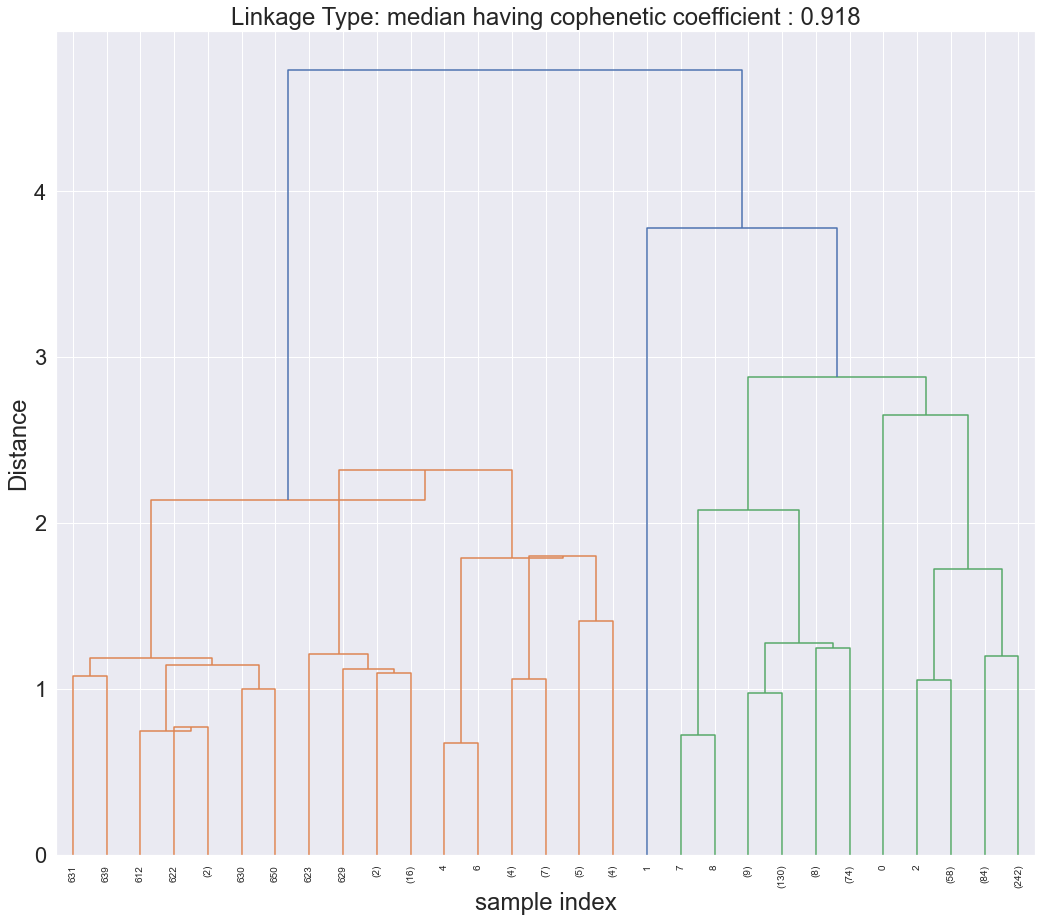

median 0.9175526892861736


In [60]:
linkage_methods=['single','complete','average','ward','median']
results_cophenetic_coef=[]
for i in linkage_methods :
    plt.figure(figsize=(15, 13))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    Z = linkage(dfsk, i)
    cc,cophn_dist=cophenet(Z,pdist(subset_scaled_df))
    dendrogram(Z,leaf_rotation=90.0,p=5,leaf_font_size=10,truncate_mode='level')
    plt.tight_layout()
    plt.title("Linkage Type: "+ i +" having cophenetic coefficient : "+str(round(cc,3)) )
    plt.show()
    results_cophenetic_coef.append((i,cc))
    print (i,cc)

In [61]:
results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','CopheneticCoefficient'])
results_cophenetic_coef_df

,LinkageMethod,CopheneticCoefficient
0,single,0.854364
1,complete,0.902413
2,average,0.931503
3,ward,0.827060
4,median,0.917553


## Observations 

- The linkage with the best cophenetic coefficient is "Average" linkage.
- The dendograms for 'ward' and 'complete' show good difference between clusters.
- Therefore we shall choose 'complete' because it has high a cophenetic coefficient and good cluster segregation.


We will bow a dendogram for the last 25 formed clusters using complete linkage to have a better view since the above dendograms are very populated

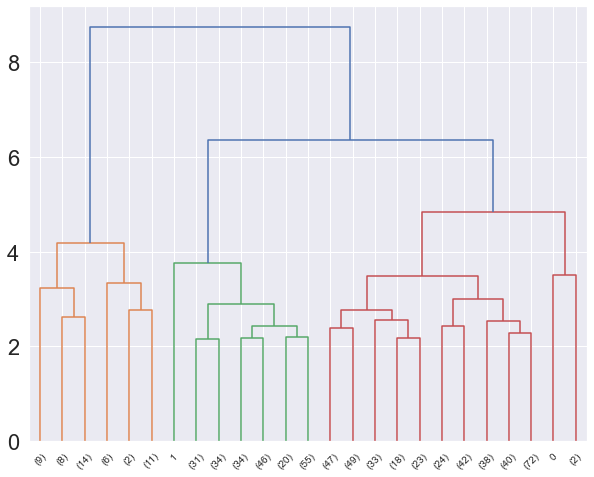

In [62]:
#use truncate_mode='lastp' to select last p formed clusters
plt.figure(figsize=(10,8))
Z = linkage(subset_scaled_df, 'complete', metric='euclidean')

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25 # show only the last p merged clusters
)
plt.show()

In [63]:
max_d=5
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')

In [64]:
set(clusters)  # So there are 3 clusters which are formed

{1, 2, 3}

## Assign the clusters label to the data set

In [65]:
dataset2=subset_scaled_df[:] #Create a duplicate of the dataset

In [66]:
dataset2['HCL']=clusters #HCL being hierachical cluster labeling

In [67]:
dataset2.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels_hierarchy,group,HCL
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0,1,3
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2,0,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0,1,3
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0,1,3
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1,2,1


## Analyse the clusters

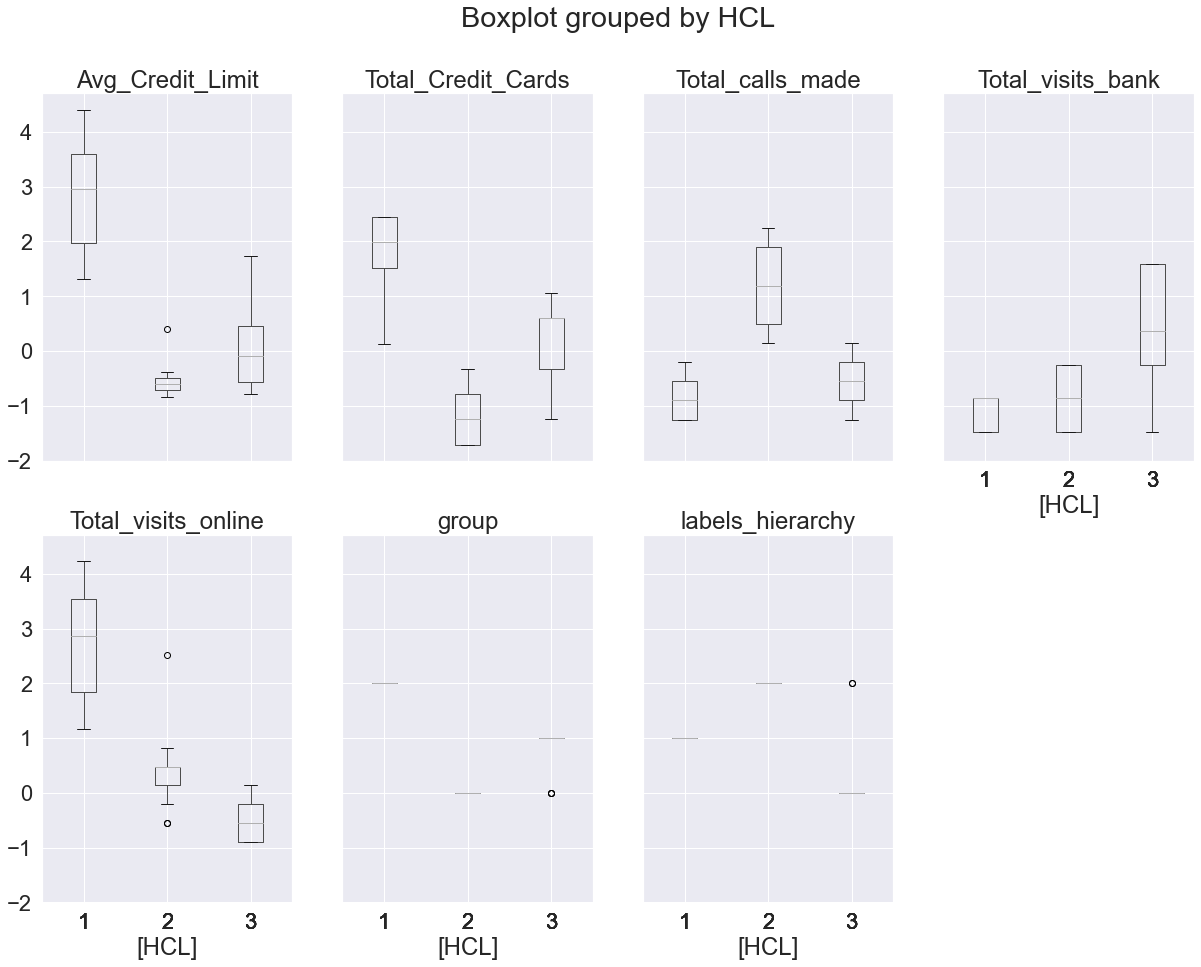

In [68]:
dataset2.boxplot(by = 'HCL',  layout=(2,4), figsize=(20, 15))
plt.show()

## Comparison between K-means and Hierarchical clustering

In [69]:
# Calculate & Print Silhoutte Score for KMeans

score = silhouette_score(KMeansData, FinalModel.labels_, metric='euclidean')

print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.617


In [70]:
Kmeans_results=KMeansData.groupby('KmeansLabel').mean()
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,Group
KmeansLabel,,,,,,,
0,-0.595796,-1.059623,-0.901518,0.322997,1.148109,2,0
1,-0.021062,0.373690,0.666395,-0.553672,-0.553005,0,1
2,2.831764,1.862226,-1.105763,2.827319,-0.874330,1,2


In [72]:
Hierarchical_results=dataset2.groupby('HCL').mean()
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels_hierarchy,group
HCL,,,,,,,
1,2.831764,1.862226,-1.105763,2.827319,-0.874330,1.000000,2.000000
2,-0.594650,-1.063316,-0.899301,0.331728,1.169620,2.000000,0.000000
3,-0.026145,0.364734,0.653043,-0.551871,-0.552107,0.010283,0.992288


## Observation


Cluster 0 of Kmeans appears similar to Cluster 2 of Hierarchical

Cluster 1 of Kmeans appears similar to Cluster 3 of Hierarchical

Cluster 2 of Kmeans appears similar to Cluster 1 of Hierarchical

#### Renaming clusters

Cluster 0 of Kmeans and Cluster 2 of Hierarchical as M1

Cluster 1 of Kmeans and Cluster 3 of Hierarchical as M2

Cluster 2 of Kmeans and Cluster 1 of Hierarchical as M3

In [101]:
Kmeans_results.index=['M1','M2','M3']
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,Group
M1,-0.595796,-1.059623,-0.901518,0.322997,1.148109,2,0
M2,-0.021062,0.373690,0.666395,-0.553672,-0.553005,0,1
M3,2.831764,1.862226,-1.105763,2.827319,-0.874330,1,2


In [102]:
Hierarchical_results.index=['M3','M1','M2']
Hierarchical_results.sort_index(inplace=True)
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels_hierarchy,group
M1,-0.594650,-1.063316,-0.899301,0.331728,1.169620,2.000000,0.000000
M2,-0.026145,0.364734,0.653043,-0.551871,-0.552107,0.010283,0.992288
M3,2.831764,1.862226,-1.105763,2.827319,-0.874330,1.000000,2.000000


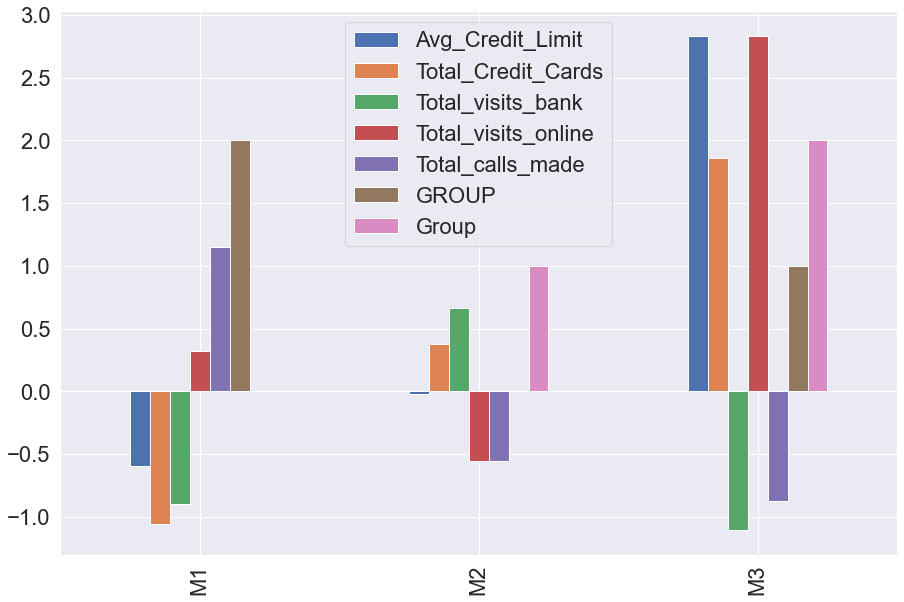

In [105]:
fig,ax = plt.subplots(figsize=(15,10));
Kmeans_results.plot.bar(ax=ax);

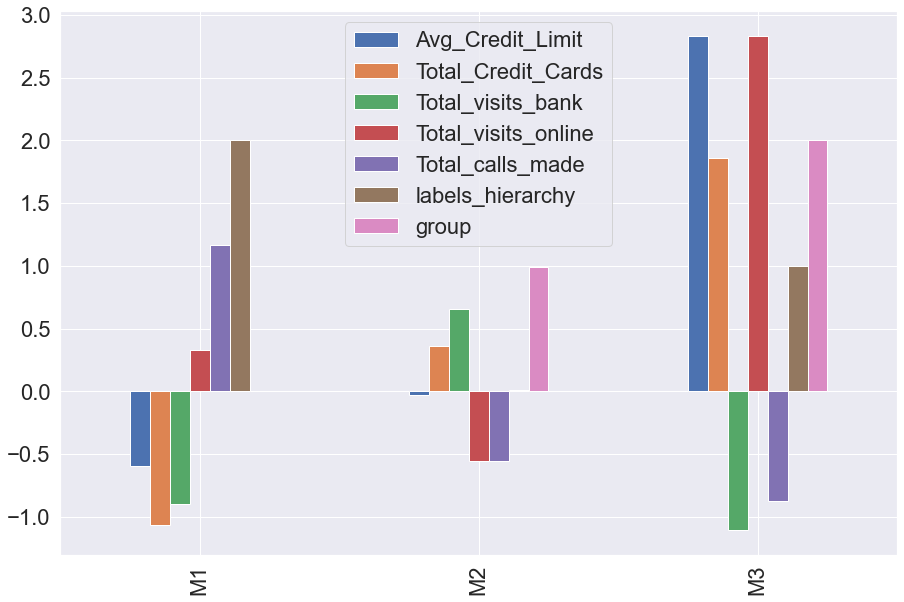

In [106]:
fig,ax = plt.subplots(figsize=(15,10));
Hierarchical_results.plot.bar(ax=ax);

## Cluster Profiles and Marketing Recommendation

Since both the clustering alogrithms are giving similar clusters so we can assign labels from any one of the algorithm to the original (non scaled) data to analyse clusters profiles ( here we are assigning labels of Kmeans , same could be done using hierarchical labels)

In [107]:
KMeansData['KmeansLabel']=KMeansData['KmeansLabel']

In [108]:
subset_scaled_df.describe

<bound method NDFrame.describe of      Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.740187           -1.249225          -0.860451   
1            0.410293           -0.787585          -1.473731   
2            0.410293            1.058973          -0.860451   
3           -0.121665            0.135694          -0.860451   
4            1.740187            0.597334          -1.473731   
..                ...                 ...                ...   
655          1.713589            2.443892          -0.860451   
656          1.314621            2.443892          -0.860451   
657          2.937092            1.520613          -0.860451   
658          3.655235            2.443892          -0.860451   
659          3.522245            1.982253          -1.473731   

     Total_visits_online  Total_calls_made  labels_hierarchy  group  
0              -0.547490         -1.251537                 0      1  
1               2.520519          1.891859               

## Insights

There are 3 different segments of customers.


## Clusters Profiles

#### Label 0 can be considered as low ranged customers
* This group contains about 34% of the customers ( 224/660 )

* These customers have a mean `Avg_Credit_Limit` around 122,000 and have 2 credit cards on an average and the maximum number of credit card as 4.

* These customers make the most calls to customer service to the bank. 


#### Label 1 can be considered medium ranged  customers
* This group has about 58% of the customers, which carries the majority  ( 386/660 )

* These customers have  `Avg_Credit_Limit` ranging from 5000.0 to 100000.0 

* These customers make the most visits to the bank but have the least visits online



#### Label 2 can be considered high ranged customers
* These are a very small group of customers, taking just 7.5% of the customers, which is the smallest group (50/660) .

* These customers have a minimum "Avg_Credit_Limit " of 84000 and have atleast 5 Credit cards .

* These customers have the least visits to the bank, but are the most active based on usage of online services.


## Business Recommendations
- For customers under the medium range, we can try to encourage them to use online services more where we can encourage them to sign up for services that might help reduce the number of trips they make to the bank. We could also encourage the customers in the low range also, to push offers and promotions that may help increase their average credit limit and inform them on the benefits of more credit cards.

- Customers in the high ranged can be targeted and be offered special deals that are tailored to them, that will incentivize them to use our services. 

- Customers who are in the low range can be targeted by the customer care employees, where they can offer them deals that will interest them, and also direct them to other services the bank has to offer, such as the online services to try and increase that group's online presence. 